In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import os
import sys

print("✓ Librerie importate")
print(f"PyTorch version: {torch.__version__}")
print(f"Device disponibile: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

✓ Librerie importate
PyTorch version: 2.7.1+cu118
Device disponibile: cuda


## 2. DATA LOADING

In [2]:
# Carica il dataset NILM ready
df = pd.read_parquet("nilm_ready_dataset.parquet")
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time').reset_index(drop=True)

print(f"Dataset NILM caricato: {df.shape[0]} righe, {df.shape[1]} colonne")
print(f"\nColonne disponibili:")
print(df.columns.tolist())

# Definisci INPUT e TARGET
# Input: Aggregate (consumo totale edificio)
# Target: seleziona l'appliance da disaggregare
TARGET_APPLIANCE = 'HeatPump'  # Puoi cambiare con: 'Oven', 'Dishwasher', 'WashingMachine', ecc.

Building = df[['Time', 'Aggregate']].copy()
Building.columns = ['_time', '_value']

Oven = df[['Time', TARGET_APPLIANCE]].copy()
Oven.columns = ['_time', '_value']

print(f"\n✓ Input (Aggregate): {Building.shape[0]} righe")
print(f"✓ Target ({TARGET_APPLIANCE}): {Oven.shape[0]} righe")
print(f"\nRange temporale: {df['Time'].min()} → {df['Time'].max()}")
df.head()

Dataset NILM caricato: 35040 righe, 14 colonne

Colonne disponibili:
['Time', 'Aggregate', 'RangeHood', 'Dryer', 'Stove', 'GarageCabinet', 'ChargingStation_Socket', 'Oven', 'RainwaterPump', 'SmappeeCharger', 'Dishwasher', 'HeatPump', 'HeatPump_Controller', 'WashingMachine']

✓ Input (Aggregate): 35040 righe
✓ Target (HeatPump): 35040 righe

Range temporale: 2024-10-20 02:15:00 → 2025-10-20 02:00:00


,Time,Aggregate,RangeHood,Dryer,Stove,GarageCabinet,ChargingStation_Socket,Oven,RainwaterPump,SmappeeCharger,Dishwasher,HeatPump,HeatPump_Controller,WashingMachine
0,2024-10-20 02:15:00,0.198563,0.000000,0.003,0.0,0.022450,0.0,0.0,0.0,0.003,0.0,0.004004,0.0,0.0
1,2024-10-20 02:30:00,0.228958,0.000002,0.003,0.0,0.024443,0.0,0.0,0.0,0.003,0.0,0.004002,0.0,0.0
2,2024-10-20 02:45:00,0.216411,0.000000,0.003,0.0,0.103922,0.0,0.0,0.0,0.003,0.0,0.004003,0.0,0.0
3,2024-10-20 03:00:00,0.170043,0.000000,0.003,0.0,0.019961,0.0,0.0,0.0,0.003,0.0,0.004001,0.0,0.0
4,2024-10-20 03:15:00,0.180233,0.000000,0.003,0.0,0.019991,0.0,0.0,0.0,0.003,0.0,0.004002,0.0,0.0


## 3. EXPLORATORY DATA ANALYSIS

In [3]:
# Analizza i dati
time_diff = Building['_time'].diff()
total_duration = Building['_time'].max() - Building['_time'].min()

print("=== DATASET NILM ===")
print(f"Intervallo minimo: {time_diff.min()}")
print(f"Intervallo massimo: {time_diff.max()}")
print(f"Intervallo medio: {time_diff.mean()}")
print(f"Durata totale: {total_duration.days} giorni")
print(f"Righe per giorno: {len(Building) / max(total_duration.days, 1):.0f}")

# Calcola sequenze per 1 giorno (96 punti = 24h * 4 punti/ora per dati ogni 15 min)
rows_per_day = 96  # 15 minuti * 96 = 24 ore
window_size = rows_per_day
print(f"\nWindow size scelto: {window_size} (sequenza di ~1 giorno con dati ogni 15 min)")

=== DATASET NILM ===
Intervallo minimo: 0 days 00:15:00
Intervallo massimo: 0 days 00:15:00
Intervallo medio: 0 days 00:15:00
Durata totale: 364 giorni
Righe per giorno: 96

Window size scelto: 96 (sequenza di ~1 giorno con dati ogni 15 min)


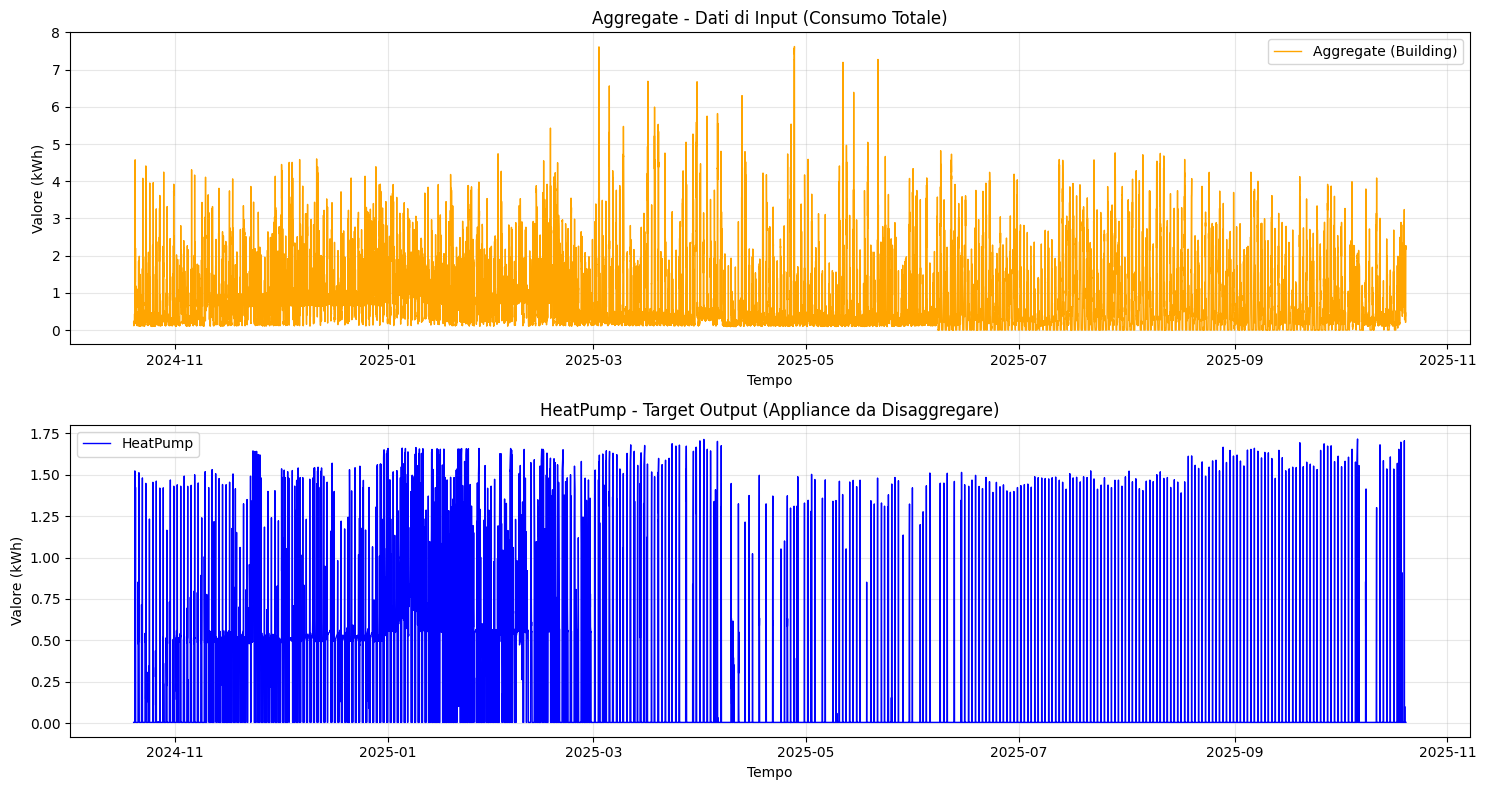

In [4]:
# Visualizza le timeline complete
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

axes[0].plot(Building['_time'], Building['_value'], linewidth=1, color='orange', label='Aggregate (Building)')
axes[0].set_title('Aggregate - Dati di Input (Consumo Totale)')
axes[0].set_xlabel('Tempo')
axes[0].set_ylabel('Valore (kWh)')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].plot(Oven['_time'], Oven['_value'], linewidth=1, color='blue', label=f'{TARGET_APPLIANCE}')
axes[1].set_title(f'{TARGET_APPLIANCE} - Target Output (Appliance da Disaggregare)')
axes[1].set_xlabel('Tempo')
axes[1].set_ylabel('Valore (kWh)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

## 4. DATA NORMALIZATION & SEQUENCE CREATION

In [5]:
# Normalizzazione dei dati
input_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit degli scaler sui dati completi
Building_values = Building[['_value']].values
Oven_values = Oven[['_value']].values

input_scaler.fit(Building_values)
target_scaler.fit(Oven_values)

# Normalizza i dati
Building_normalized = input_scaler.transform(Building_values)
Oven_normalized = target_scaler.transform(Oven_values)

print(f"✓ Dati normalizzati")
print(f"  Building: min={Building_normalized.min():.4f}, max={Building_normalized.max():.4f}")
print(f"  Oven: min={Oven_normalized.min():.4f}, max={Oven_normalized.max():.4f}")

✓ Dati normalizzati
  Building: min=0.0000, max=1.0000
  Oven: min=0.0000, max=1.0000


In [6]:
def create_sequences(input_data, target_data, seq_length, step=1):
    """
    Crea sequenze per il modello CNN Seq2Seq
    Input: Building (input_data)
    Target: Oven (target_data)
    """
    input_sequences = []
    target_sequences = []
    timestamps = []

    max_idx = min(len(input_data), len(target_data)) - seq_length

    for i in range(0, max_idx, step):
        input_seq = input_data[i:i+seq_length]
        target_seq = target_data[i:i+seq_length]
        
        input_sequences.append(input_seq)
        target_sequences.append(target_seq)
        timestamps.append(i)

    return input_sequences, target_sequences, timestamps

print("✓ Funzione create_sequences definita")

✓ Funzione create_sequences definita


In [7]:
# Train/Test split TEMPORALE (80% train, 20% test)
# IMPORTANTE: split sui dati grezzi PRIMA di creare le sequenze per evitare data leakage

train_ratio = 0.8
split_idx = int(len(Building_normalized) * train_ratio)

# Split dei dati normalizzati
Building_train = Building_normalized[:split_idx]
Building_test = Building_normalized[split_idx:]
Oven_train = Oven_normalized[:split_idx]
Oven_test = Oven_normalized[split_idx:]

print(f"✓ Train/Test Split temporale:")
print(f"  Training: {len(Building_train):,} punti ({train_ratio*100:.0f}%)")
print(f"  Test: {len(Building_test):,} punti ({(1-train_ratio)*100:.0f}%)")

# Crea le sequenze SEPARATE per train e test
sequence_step = 1

print(f"\nCreazione sequenze con window_size={window_size}, step={sequence_step}...")

# Sequenze di TRAINING
seq_building_train, seq_oven_train, timestamps_train = create_sequences(
    Building_train, Oven_train, 
    seq_length=window_size,
    step=sequence_step
)

# Sequenze di TEST
seq_building_test, seq_oven_test, timestamps_test = create_sequences(
    Building_test, Oven_test, 
    seq_length=window_size,
    step=sequence_step
)

print(f"\n✓ Sequenze TRAINING: {len(seq_building_train)}")
print(f"✓ Sequenze TEST: {len(seq_building_test)}")
print(f"✓ Dimensione sequenza: {seq_building_train[0].shape}")
print(f"\n⚠️ Train e Test sono COMPLETAMENTE SEPARATI temporalmente!")

✓ Train/Test Split temporale:
  Training: 28,032 punti (80%)
  Test: 7,008 punti (20%)

Creazione sequenze con window_size=96, step=1...

✓ Sequenze TRAINING: 27936
✓ Sequenze TEST: 6912
✓ Dimensione sequenza: (96, 1)

⚠️ Train e Test sono COMPLETAMENTE SEPARATI temporalmente!


In [8]:
type(seq_building_train), type(seq_oven_train), len(seq_building_train)

(list, list, 27936)

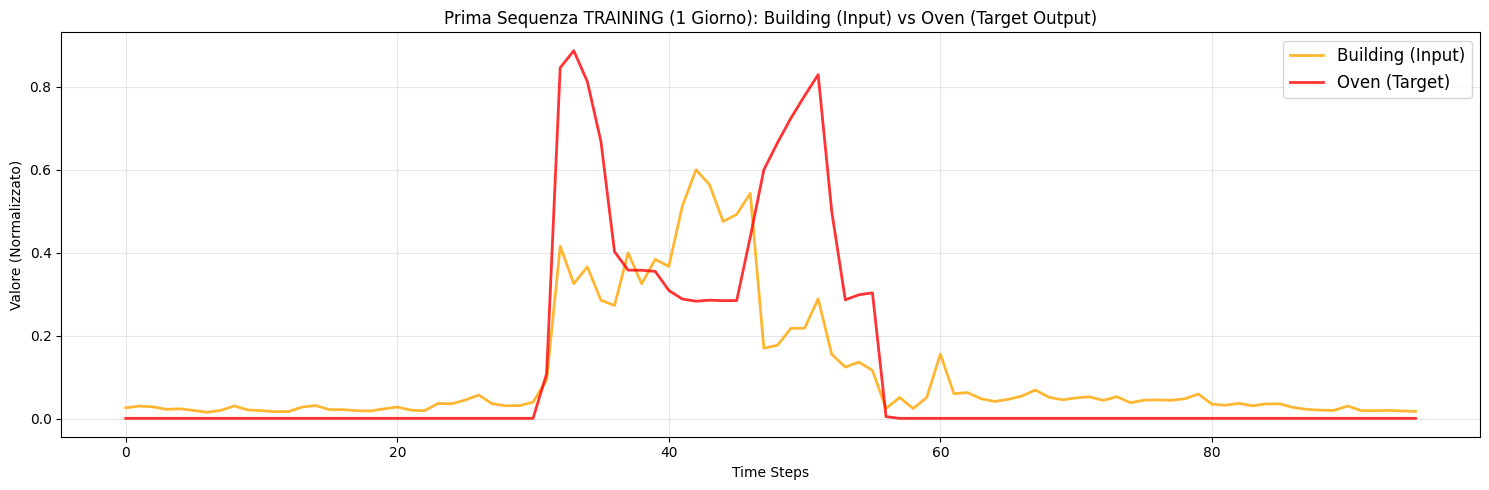

In [9]:
# Visualizza il confronto della prima sequenza di TRAINING (normalizzata)
plt.figure(figsize=(15, 5))
plt.plot(range(window_size), seq_building_train[0].flatten(), linewidth=2, color='orange', label='Building (Input)', alpha=0.8)
plt.plot(range(window_size), seq_oven_train[0].flatten(), linewidth=2, color='red', label='Oven (Target)', alpha=0.8)
plt.xlabel('Time Steps')
plt.ylabel('Valore (Normalizzato)')
plt.title('Prima Sequenza TRAINING (1 Giorno): Building (Input) vs Oven (Target Output)')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. MODEL DEFINITION - CNN Seq2Seq

In [10]:
# Modello U-Net 1D per NILM - molto più efficace per catturare i picchi

class UNet1D(nn.Module):
    """
    U-Net 1D per disaggregazione energetica.
    Le skip connections preservano i dettagli temporali dei picchi.
    """
    def __init__(self, input_channels=1, base_channels=64):
        super(UNet1D, self).__init__()
        
        # Encoder (downsampling path)
        self.enc1 = self._conv_block(input_channels, base_channels)
        self.enc2 = self._conv_block(base_channels, base_channels * 2)
        self.enc3 = self._conv_block(base_channels * 2, base_channels * 4)
        self.enc4 = self._conv_block(base_channels * 4, base_channels * 8)
        
        # Bottleneck
        self.bottleneck = self._conv_block(base_channels * 8, base_channels * 16)
        
        # Decoder (upsampling path) con skip connections
        self.dec4 = self._conv_block(base_channels * 16 + base_channels * 8, base_channels * 8)
        self.dec3 = self._conv_block(base_channels * 8 + base_channels * 4, base_channels * 4)
        self.dec2 = self._conv_block(base_channels * 4 + base_channels * 2, base_channels * 2)
        self.dec1 = self._conv_block(base_channels * 2 + base_channels, base_channels)
        
        # Output
        self.output = nn.Sequential(
            nn.Conv1d(base_channels, 1, kernel_size=1),
            nn.ReLU()  # ReLU invece di Sigmoid - output >= 0
        )
        
        # Pooling e upsampling
        self.pool = nn.MaxPool1d(2)
        self.up = nn.Upsample(scale_factor=2, mode='linear', align_corners=True)
        
    def _conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.LeakyReLU(0.1),
            nn.Conv1d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1)
        )
    
    def forward(self, x):
        # x: (batch, seq_len, 1) -> (batch, 1, seq_len)
        x = x.transpose(1, 2)
        
        # Encoder con salvataggio per skip connections
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        
        # Bottleneck
        b = self.bottleneck(self.pool(e4))
        
        # Decoder con skip connections
        d4 = self.dec4(torch.cat([self.up(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up(d2), e1], dim=1))
        
        # Output
        out = self.output(d1)
        
        # (batch, 1, seq_len) -> (batch, seq_len, 1)
        return out.transpose(1, 2)

print("✓ Modello U-Net 1D definito")
print("  - Skip connections per preservare dettagli temporali")
print("  - Encoder-Decoder simmetrico")
print("  - ReLU output (valori >= 0)")

✓ Modello U-Net 1D definito
  - Skip connections per preservare dettagli temporali
  - Encoder-Decoder simmetrico
  - ReLU output (valori >= 0)


## 6. DATA PREPARATION FOR TRAINING

In [11]:
class EnergyDataset(Dataset):
    def __init__(self, input_sequences, target_sequences):
        self.input_sequences = [torch.FloatTensor(seq) for seq in input_sequences]
        self.target_sequences = [torch.FloatTensor(seq) for seq in target_sequences]
    
    def __len__(self):
        return len(self.input_sequences)
    
    def __getitem__(self, idx):
        return self.input_sequences[idx], self.target_sequences[idx]

print("✓ EnergyDataset definito")

✓ EnergyDataset definito


## 7. TRAINING

In [12]:
# ===== CONFIGURAZIONE E TRAINING =====

batch_size = 32
base_channels = 32  # Canali base per U-Net
num_epochs = 200
learning_rate = 0.001

# Dataset
train_dataset = EnergyDataset(seq_building_train, seq_oven_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

print(f"Sequenze TRAINING: {len(seq_building_train):,}")
print(f"Sequenze TEST: {len(seq_building_test):,}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

# Setup modello U-Net
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet1D(input_channels=1, base_channels=base_channels).to(device)
print(f"Parametri: {sum(p.numel() for p in model.parameters()):,}")

# === LOSS FUNCTION MIGLIORATA ===
class NILMLoss(nn.Module):
    """
    Loss per NILM con focus estremo sui picchi.
    """
    def __init__(self, alpha=0.5):
        super(NILMLoss, self).__init__()
        self.alpha = alpha
        self.mse = nn.MSELoss(reduction='none')
        
    def forward(self, pred, target):
        # MSE base
        mse = self.mse(pred, target)
        
        # Peso adattivo: pesa MOLTO di più dove il target è alto
        # Normalizza il target per avere pesi tra 1 e 100
        weight = 1.0 + 99.0 * (target / (target.max() + 1e-8))
        
        # Loss pesata
        weighted_loss = (mse * weight).mean()
        
        # Penalità per sotto-predizioni (quando target > pred)
        under_pred = torch.clamp(target - pred, min=0)
        under_penalty = (under_pred ** 2 * weight * 2).mean()
        
        # MAE per stabilità
        mae = torch.abs(pred - target).mean()
        
        return weighted_loss + under_penalty + self.alpha * mae

criterion = NILMLoss(alpha=0.3)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=30, T_mult=2)

print("✓ NILMLoss configurata (peso adattivo sui picchi)")
print("✓ CosineAnnealingWarmRestarts scheduler attivo")

Sequenze TRAINING: 27,936
Sequenze TEST: 6,912
Device: GPU
Parametri: 2,623,233
✓ NILMLoss configurata (peso adattivo sui picchi)
✓ CosineAnnealingWarmRestarts scheduler attivo


In [23]:
import time

# Training loop con validation
train_losses = []
best_loss = float('inf')
patience, patience_counter = 25, 0  # Più pazienza

print(f"🚀 Training U-Net ({num_epochs} epoche, early stopping patience={patience})\n")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    start = time.time()
    lr_history = []
    
    for inp, tgt in train_loader:
        inp, tgt = inp.to(device), tgt.to(device)
        
        pred = model(inp)
        loss = criterion(pred, tgt)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    scheduler.step()
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    current_lr = scheduler.get_last_lr()[0]
    lr_history.append(current_lr)
    
    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {avg_loss:.6f} | LR: {scheduler.get_last_lr()[0]:.6f} | {time.time()-start:.1f}s")
    
    if patience_counter >= patience:
        print(f"\n⚠️ Early stopping at epoch {epoch+1}")
        break

model.load_state_dict(best_model_state)
print(f"\n✓ Training completato! Best loss: {best_loss:.6f}")

🚀 Training U-Net (200 epoche, early stopping patience=25)

Epoch  10 | Loss: 0.020599 | LR: 0.000844 | 10.9s
Epoch  20 | Loss: 0.019132 | LR: 0.000739 | 10.9s


KeyboardInterrupt: 

## 8. RESULTS & VISUALIZATION

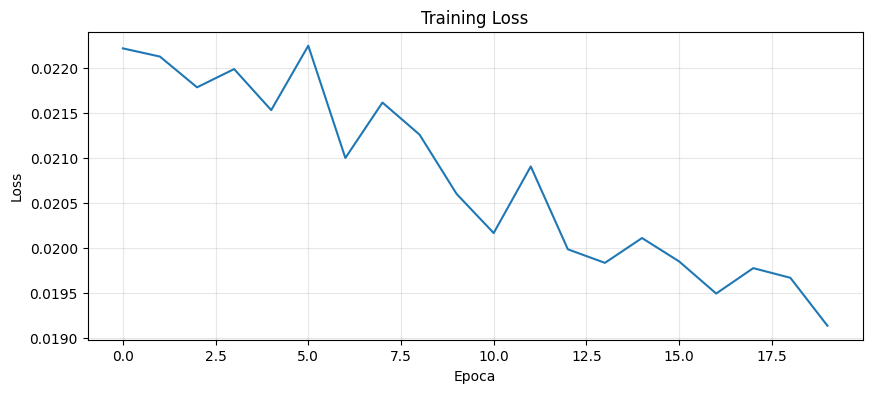

Loss: 0.0222 → 0.0191 (best: 0.0191)


In [24]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses)
plt.plot(lr_history, linestyle='--', color='gray', alpha=0.5, label='Learning Rate')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)
plt.show()
print(f"Loss: {train_losses[0]:.4f} → {train_losses[-1]:.4f} (best: {best_loss:.4f})")

In [15]:
# # Salva il modello (commentato)
# model_path = f"seq2seq_cnn_{TARGET_APPLIANCE.lower()}_model.pth"
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'hyperparameters': {
#         'hidden_channels': hidden_channels,
#         'num_layers': num_layers,
#         'window_size': window_size,
#         'target_appliance': TARGET_APPLIANCE
#     },
#     'input_scaler': input_scaler,
#     'target_scaler': target_scaler
# }, model_path)
# print(f"✓ Modello salvato: {model_path}")
print("⚠️ Salvataggio modello commentato - decommentare quando soddisfatti")

⚠️ Salvataggio modello commentato - decommentare quando soddisfatti


## 9. INFERENCE & EVALUATION

In [27]:
# Valutazione su TEST SET
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model.eval()
test_idx = 10  # Sequenza di test

with torch.no_grad():
    inp = torch.FloatTensor(seq_building_test[test_idx]).unsqueeze(0).to(device)
    pred = model(inp).cpu().numpy().squeeze()
    actual = seq_oven_test[test_idx].squeeze()

# Denormalizza
pred_denorm = target_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
actual_denorm = target_scaler.inverse_transform(actual.reshape(-1, 1)).flatten()

mse = mean_squared_error(actual_denorm, pred_denorm)
mae = mean_absolute_error(actual_denorm, pred_denorm)
r2 = r2_score(actual_denorm, pred_denorm)

print(f"📊 Metriche TEST (sequenza {test_idx}):")
print(f"  MSE: {mse:.6f} | MAE: {mae:.6f} | R²: {r2:.4f}")

📊 Metriche TEST (sequenza 10):
  MSE: 0.002039 | MAE: 0.008985 | R²: 0.9542


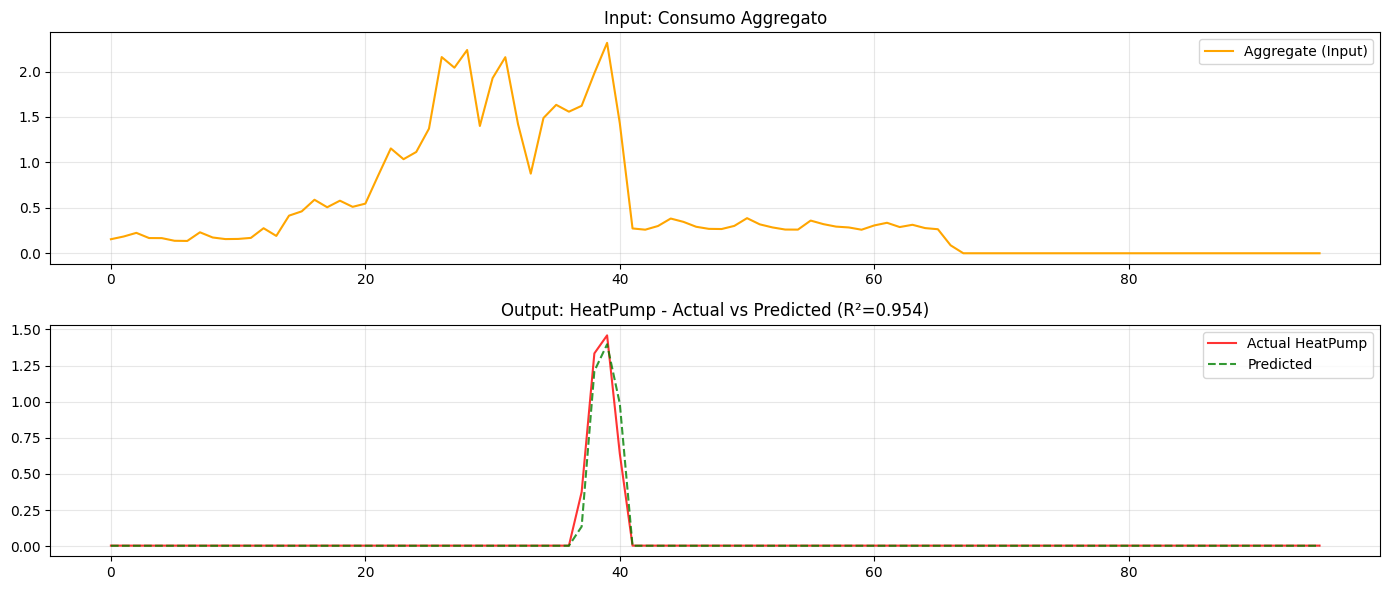

In [28]:
# Visualizzazione predizioni vs actual
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# Input
input_denorm = input_scaler.inverse_transform(seq_building_test[test_idx]).flatten()
axes[0].plot(input_denorm, color='orange', label='Aggregate (Input)')
axes[0].set_title('Input: Consumo Aggregato')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Output: Predizione vs Actual
axes[1].plot(actual_denorm, color='red', label=f'Actual {TARGET_APPLIANCE}', alpha=0.8)
axes[1].plot(pred_denorm, color='green', linestyle='--', label='Predicted', alpha=0.8)
axes[1].set_title(f'Output: {TARGET_APPLIANCE} - Actual vs Predicted (R²={r2:.3f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# Valutazione su multiple sequenze del test set
num_samples = min(300, len(seq_building_test))
indices = np.linspace(0, len(seq_building_test)-1, num_samples, dtype=int)
metrics = {'mse': [], 'mae': [], 'r2': []}

model.eval()
with torch.no_grad():
    for idx in indices:
        inp = torch.FloatTensor(seq_building_test[idx]).unsqueeze(0).to(device)
        pred = model(inp).cpu().numpy().squeeze()
        actual = seq_oven_test[idx].squeeze()
        
        pred_d = target_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
        actual_d = target_scaler.inverse_transform(actual.reshape(-1, 1)).flatten()
        
        metrics['mse'].append(mean_squared_error(actual_d, pred_d))
        metrics['mae'].append(mean_absolute_error(actual_d, pred_d))
        metrics['r2'].append(r2_score(actual_d, pred_d))

print(f"📊 Metriche su {num_samples} sequenze TEST:")
print(f"  MSE: {np.mean(metrics['mse']):.6f} ± {np.std(metrics['mse']):.6f}")
print(f"  MAE: {np.mean(metrics['mae']):.6f} ± {np.std(metrics['mae']):.6f}")
print(f"  R²:  {np.mean(metrics['r2']):.4f} ± {np.std(metrics['r2']):.4f}")

📊 Metriche su 300 sequenze TEST:
  MSE: 0.106280 ± 0.131807
  MAE: 0.113196 ± 0.120299
  R²:  -15367199.5064 ± 134379775.1450
